## Importing libraries and Dataset


In [1]:
# General imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from random import randint

from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from lightgbm import early_stopping
from sklearn.ensemble import VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import joblib
import h5py
import io

# Evaluation imports
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
# Importing dataset

import os

# List all files in the dataset directory
file_path = '/kaggle/input/fetal-health/fetal_health.csv'
data = pd.read_csv(file_path)
#print(os.listdir("/kaggle/input/fetal-health"))
#data = pd.read_csv(url)

In [3]:
# Detecting and handling duplicates
duplicates = data.copy()
duplicates.drop_duplicates(inplace=True)

print('Total number of duplicates are:', data.shape[0] - duplicates.shape[0])
data = duplicates.copy()

Total number of duplicates are: 13


In [4]:
# Detecting and handling duplicates
duplicates = data.copy()
duplicates.drop_duplicates(inplace=True)

print('Total number of duplicates are:', data.shape[0] - duplicates.shape[0])

# Assign cleaned data back to the original variable
data = duplicates.copy()

Total number of duplicates are: 0


In [5]:
data.shape

(2113, 22)

In [6]:
data.columns

Index(['baseline value', 'accelerations', 'fetal_movement',
       'uterine_contractions', 'light_decelerations', 'severe_decelerations',
       'prolongued_decelerations', 'abnormal_short_term_variability',
       'mean_value_of_short_term_variability',
       'percentage_of_time_with_abnormal_long_term_variability',
       'mean_value_of_long_term_variability', 'histogram_width',
       'histogram_min', 'histogram_max', 'histogram_number_of_peaks',
       'histogram_number_of_zeroes', 'histogram_mode', 'histogram_mean',
       'histogram_median', 'histogram_variance', 'histogram_tendency',
       'fetal_health'],
      dtype='object')

In [7]:
data.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0,2.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0,1.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0,1.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0,1.0


# Exploratory data analysis

In [8]:
data.describe().T.iloc[:, 1:].style.background_gradient('Blues')

,mean,std,min,25%,50%,75%,max
baseline value,133.304780,9.837451,106.000000,126.000000,133.000000,140.000000,160.000000
accelerations,0.003188,0.003871,0.000000,0.000000,0.002000,0.006000,0.019000
fetal_movement,0.009517,0.046804,0.000000,0.000000,0.000000,0.003000,0.481000
uterine_contractions,0.004387,0.002941,0.000000,0.002000,0.005000,0.007000,0.015000
light_decelerations,0.001901,0.002966,0.000000,0.000000,0.000000,0.003000,0.015000
severe_decelerations,0.000003,0.000057,0.000000,0.000000,0.000000,0.000000,0.001000
prolongued_decelerations,0.000159,0.000592,0.000000,0.000000,0.000000,0.000000,0.005000
abnormal_short_term_variability,46.993848,17.177782,12.000000,32.000000,49.000000,61.000000,87.000000
mean_value_of_short_term_variability,1.335021,0.884368,0.200000,0.700000,1.200000,1.700000,7.000000
percentage_of_time_with_abnormal_long_term_variability,9.795078,18.337073,0.000000,0.000000,0.000000,11.000000,91.000000


Text(0, 0.5, 'Count')

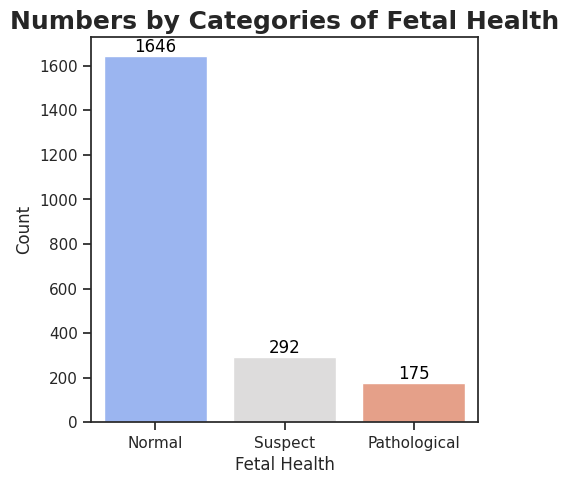

In [9]:
# Quantitative distribution histogram according to fetal health status
sns.set(style='ticks')
plt.figure(figsize=(5,5))
fh_status = sns.countplot(x='fetal_health', data=data, palette='coolwarm')

for number, count in enumerate(data['fetal_health'].value_counts()):fh_status.text(number, count, str(count), ha='center', va='bottom', fontsize=12, color='black')

plt.title('Numbers by Categories of Fetal Health', fontsize=18, fontweight='bold')

plt.xticks([0, 1, 2], ['Normal', 'Suspect', 'Pathological'])
plt.xlabel('Fetal Health')
plt.ylabel('Count')

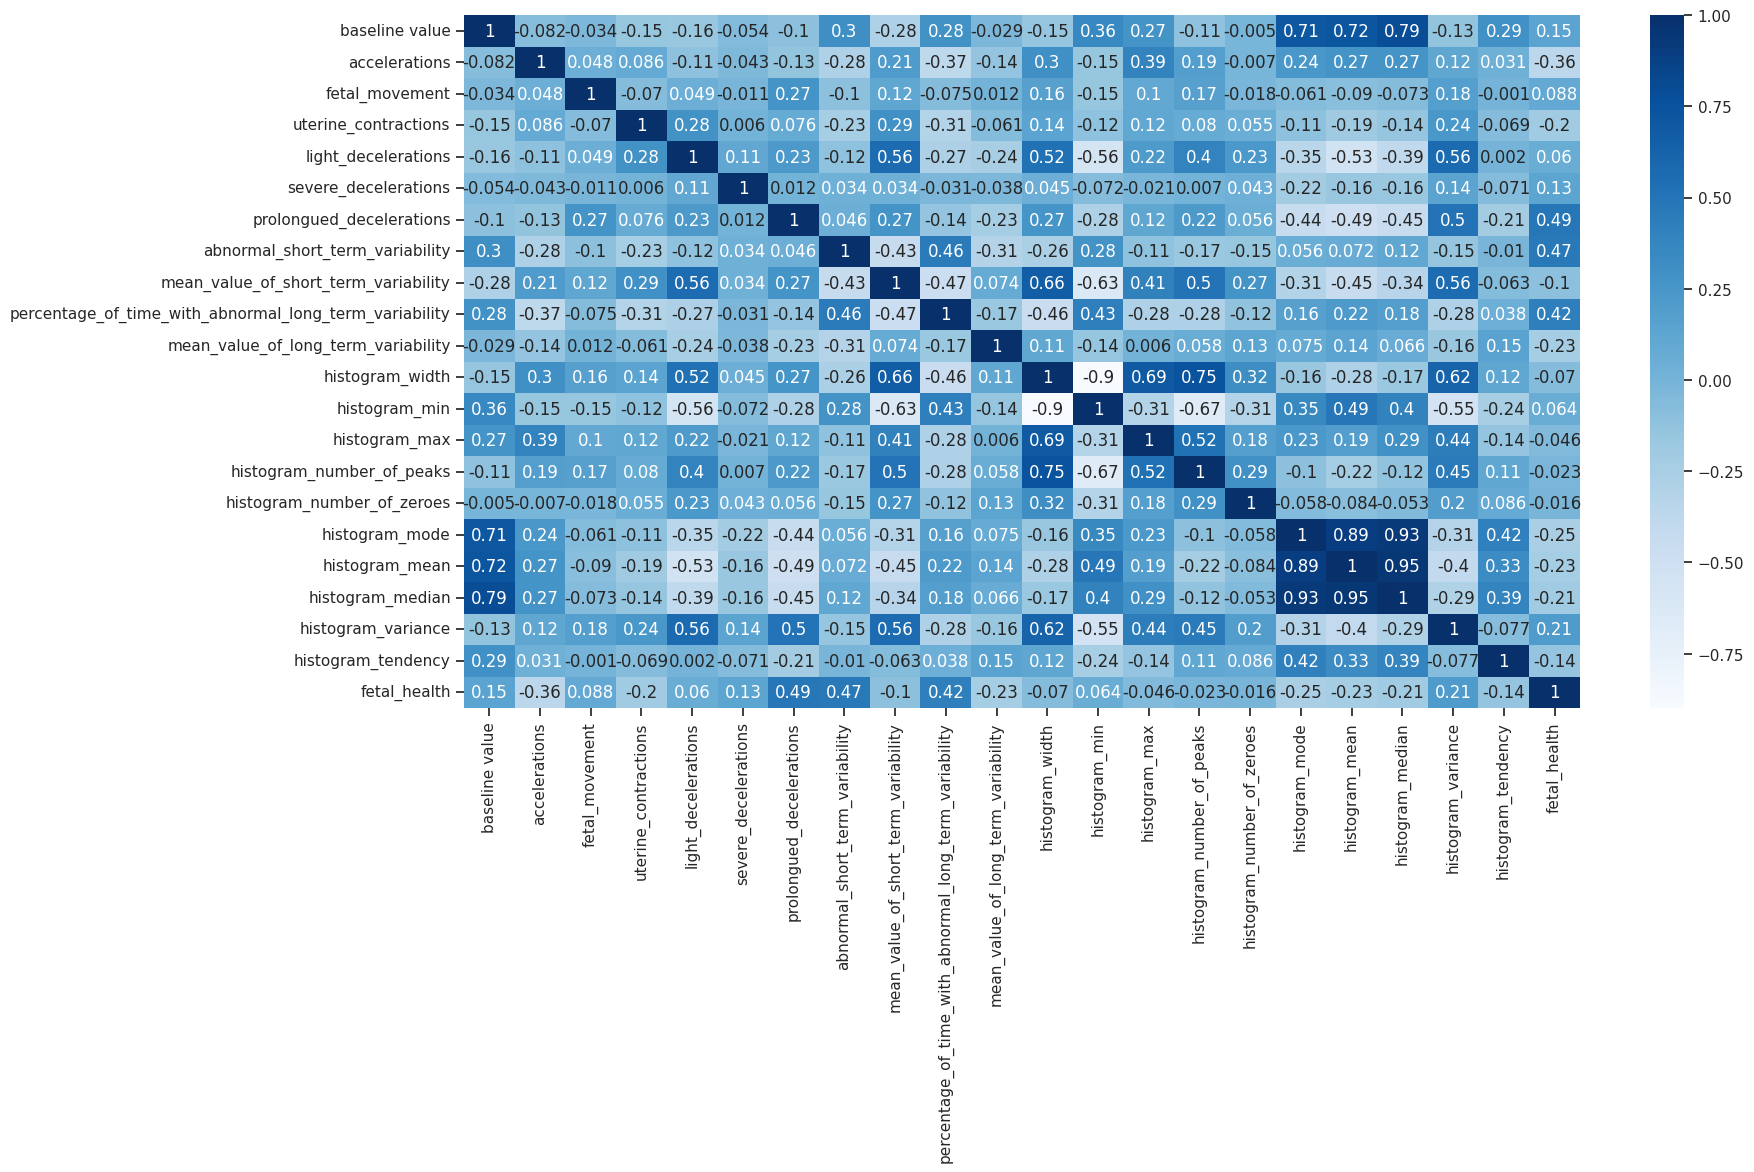

In [10]:
plt.figure(figsize=(18,9))
sns.heatmap(data.corr(numeric_only=True).round(3), cmap='Blues', annot=True)
plt.show()


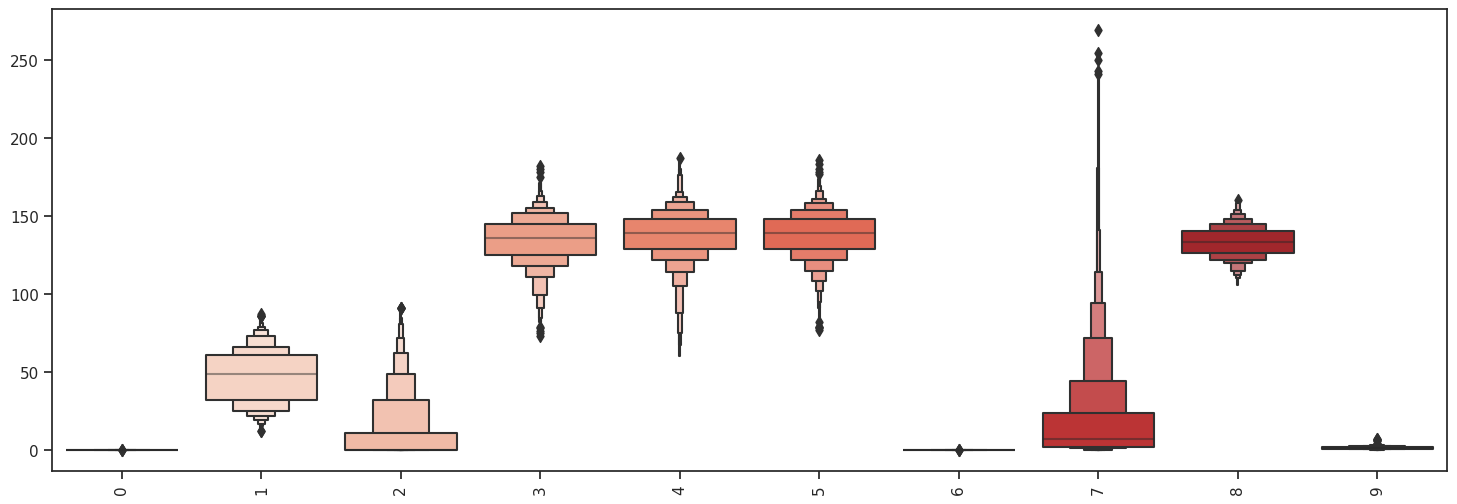

In [11]:
import warnings
data_vis = data['prolongued_decelerations'], data['abnormal_short_term_variability'], data['percentage_of_time_with_abnormal_long_term_variability'], data['histogram_mean'], data['histogram_mode'], data['histogram_median'], data['accelerations'], data['histogram_variance'], data['baseline value'], data['mean_value_of_short_term_variability']
warnings.filterwarnings("ignore")
plt.figure(figsize=(18,6))
sns.boxenplot(data_vis, palette='Reds')
plt.xticks(rotation=90)
plt.show()

# Data Preprocessing

In [12]:
# Feature selection with Genetic Algorithm
X = data.drop(['fetal_health'], axis=1)
y = data['fetal_health']

In [13]:
def initilization_of_population(size,n_feat):  # To initialize a random population.
    population = []
    for i in range(size):
        chromosome = np.ones(n_feat, dtype = np.bool_)
        chromosome[:int(0.3*n_feat)]=False
        np.random.shuffle(chromosome)
        population.append(chromosome)
    return population


def fitness_score(population):  # Returns the best parents along with their score.
    scores = []
    for chromosome in population:
        logmodel.fit(X_train.iloc[:, chromosome], y_train)
        predictions = logmodel.predict(X_test.iloc[:, chromosome])
        scores.append(accuracy_score(y_test, predictions))
    scores, population = np.array(scores), np.array(population)
    inds = np.argsort(scores)
    return list(scores[inds][::-1]), list(population[inds, :][::-1])


def selection(pop_after_fit,n_parents):  # Selection of the best parents.
    population_nextgen = []
    for i in range(n_parents):
        population_nextgen.append(pop_after_fit[i])
    return population_nextgen


def crossover(pop_after_sel):  # Picks half of the first parent and half of the second parent.
    pop_nextgen = pop_after_sel
    for i in range(0,len(pop_after_sel),2):
        new_par = []
        child_1 , child_2 = pop_nextgen[i] , pop_nextgen[i+1]
        new_par = np.concatenate((child_1[:len(child_1)//2],child_2[len(child_1)//2:]))
        pop_nextgen.append(new_par)
    return pop_nextgen


def mutation(pop_after_cross,mutation_rate,n_feat):  # Randomly flips selected bits from the crossover child.
    mutation_range = int(mutation_rate*n_feat)
    pop_next_gen = []
    for n in range(0,len(pop_after_cross)):
        chromo = pop_after_cross[n]
        rand_pos = []
        for i in range(0,mutation_range):
            pos = randint(0,n_feat-1)
            rand_pos.append(pos)
        for j in rand_pos:
            chromo[j] = not chromo[j]
        pop_next_gen.append(chromo)
    return pop_next_gen


def generations(df, label, size, n_feat, n_parents, mutation_rate, n_gen, X_train, X_test, y_train, y_test):  # Executes all the above functions for the specified number of generations.
    best_chromo = []
    best_score = []
    overall_score = -float('inf')  # Initialize with a very low value
    best_index = 0

    population_nextgen = initilization_of_population(size, n_feat)
    for i in range(n_gen):
        scores, pop_after_fit = fitness_score(population_nextgen)
        print('Best score in generation', i+1, ':', scores[:1])
        if scores[0] > overall_score:
          overall_score = scores[0]
          best_index = i

        pop_after_sel = selection(pop_after_fit, n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross, mutation_rate, n_feat)
        best_chromo.append(pop_after_fit[0])
        best_score.append(scores[0])

    print('Overall best score:', overall_score)
    print('Overall best score index:', best_index)

    return best_chromo, best_score

In [14]:
logmodel = RandomForestClassifier(n_estimators=200, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y)
chromo_df, score = generations(X, y, size=80, n_feat = X.shape[1], n_parents = 64, mutation_rate = 0.20, n_gen = 5, X_train = X_train, X_test = X_test, y_train = y_train, y_test = y_test)


Best score in generation 1 : [0.943289224952741]
Best score in generation 2 : [0.943289224952741]
Best score in generation 3 : [0.945179584120983]
Best score in generation 4 : [0.9489603024574669]
Best score in generation 5 : [0.943289224952741]
Overall best score: 0.9489603024574669
Overall best score index: 3


In [15]:
# Setting best index
best_index = score.index(max(score))
best_index

3

In [16]:
chromo_df[best_index]

array([ True,  True,  True, False,  True,  True,  True,  True, False,
        True,  True,  True,  True, False,  True, False, False, False,
       False,  True, False])

In [17]:
# Copying to another dataset to keep original one intact while making changes.
X1 = X.copy()
X1.head()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_width,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency
0,120.0,0.000,0.0,0.000,0.000,0.0,0.0,73.0,0.5,43.0,...,64.0,62.0,126.0,2.0,0.0,120.0,137.0,121.0,73.0,1.0
1,132.0,0.006,0.0,0.006,0.003,0.0,0.0,17.0,2.1,0.0,...,130.0,68.0,198.0,6.0,1.0,141.0,136.0,140.0,12.0,0.0
2,133.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.1,0.0,...,130.0,68.0,198.0,5.0,1.0,141.0,135.0,138.0,13.0,0.0
3,134.0,0.003,0.0,0.008,0.003,0.0,0.0,16.0,2.4,0.0,...,117.0,53.0,170.0,11.0,0.0,137.0,134.0,137.0,13.0,1.0
4,132.0,0.007,0.0,0.008,0.000,0.0,0.0,16.0,2.4,0.0,...,117.0,53.0,170.0,9.0,0.0,137.0,136.0,138.0,11.0,1.0


In [18]:
# Dropping features not selected through Genetic Algorithm
for i in X1.columns:
  if i not in X.columns[chromo_df[best_index]]:
    X1 = X1.drop(i, axis=1)

In [19]:
# Setting best index
best_index = score.index(max(score))
best_index

3

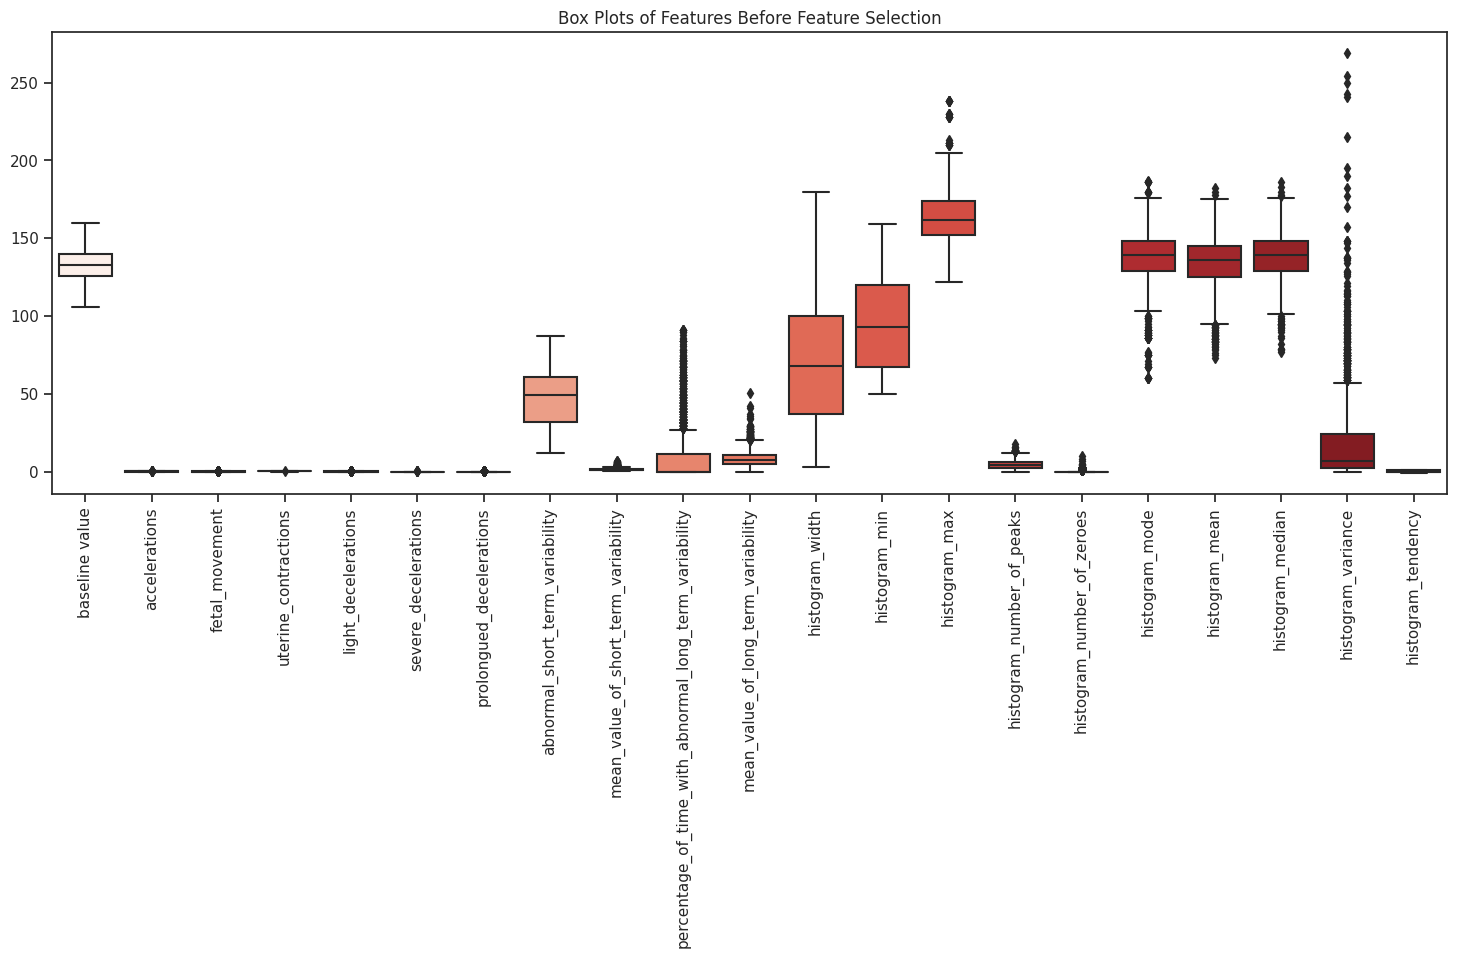

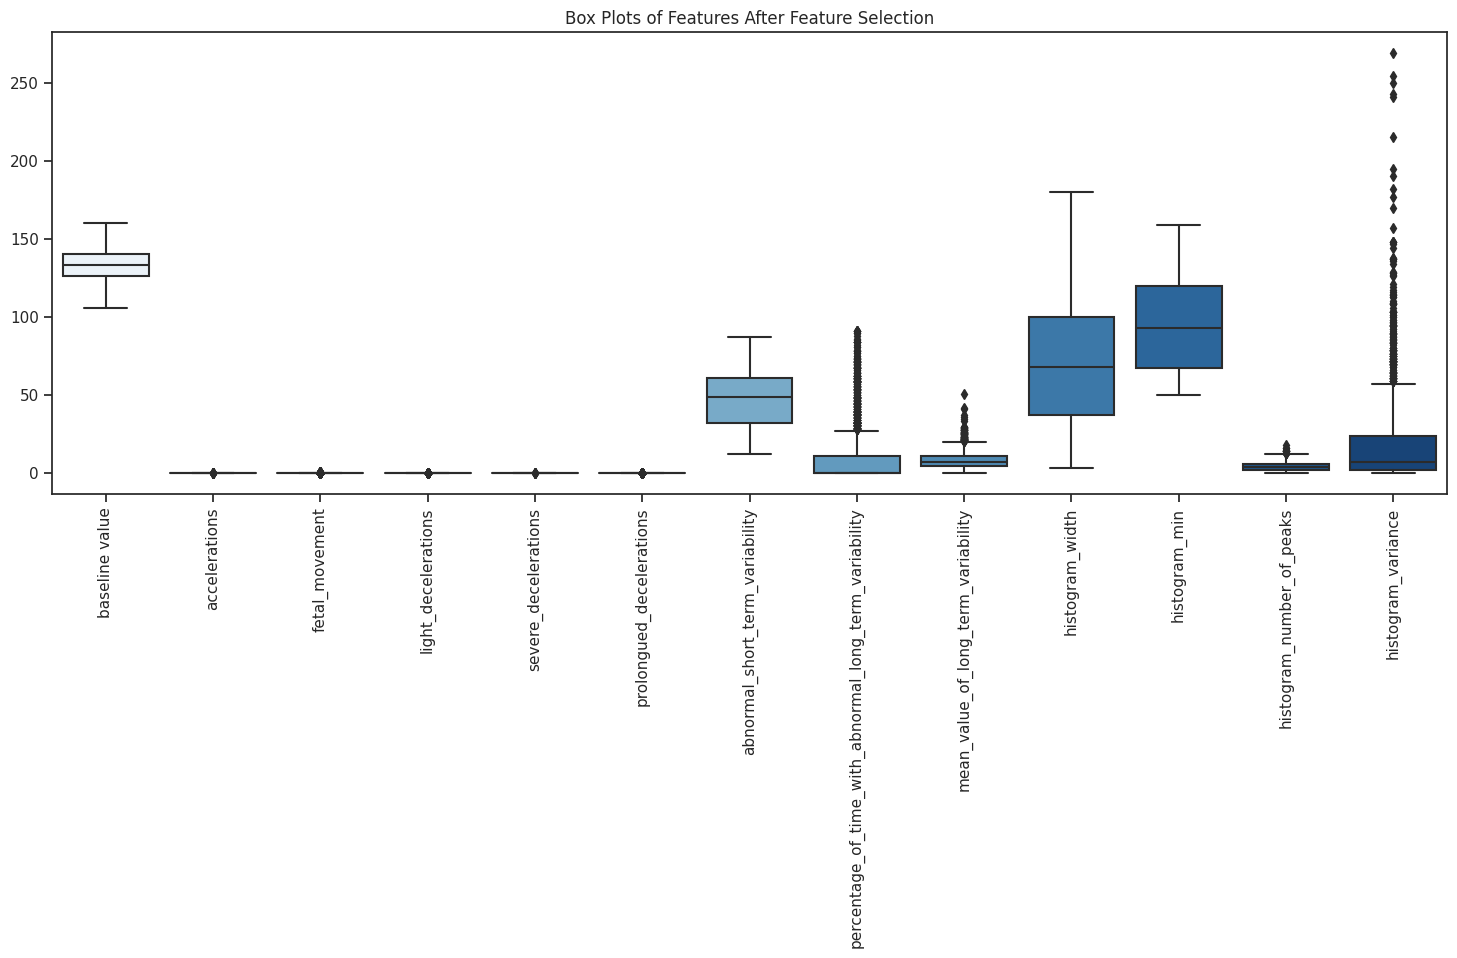

In [20]:
# Create box plots for features before feature selection
plt.figure(figsize=(18, 6))
sns.boxplot(data=X, palette='Reds')
plt.title('Box Plots of Features Before Feature Selection')
plt.xticks(rotation=90)
plt.show()

# Create box plots for features after feature selection
plt.figure(figsize=(18, 6))
sns.boxplot(data=X1, palette='Blues')
plt.title('Box Plots of Features After Feature Selection')
plt.xticks(rotation=90)
plt.show()

In [21]:
X1.head()

,baseline value,accelerations,fetal_movement,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,mean_value_of_long_term_variability,histogram_width,histogram_min,histogram_number_of_peaks,histogram_variance
0,120.0,0.000,0.0,0.000,0.0,0.0,73.0,43.0,2.4,64.0,62.0,2.0,73.0
1,132.0,0.006,0.0,0.003,0.0,0.0,17.0,0.0,10.4,130.0,68.0,6.0,12.0
2,133.0,0.003,0.0,0.003,0.0,0.0,16.0,0.0,13.4,130.0,68.0,5.0,13.0
3,134.0,0.003,0.0,0.003,0.0,0.0,16.0,0.0,23.0,117.0,53.0,11.0,13.0
4,132.0,0.007,0.0,0.000,0.0,0.0,16.0,0.0,19.9,117.0,53.0,9.0,11.0


In [22]:
X1.shape

(2113, 13)

In [24]:
# Copying dataset after confirming Feature Selection
X = X1.copy()

In [25]:
X.shape

(2113, 13)

In [28]:
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [30]:
# Defining function to scale dataset
def scale_dataset(dataframe):
  X = data.drop(['fetal_health'], axis=1)
  y = data['fetal_health']

  scaler = StandardScaler()
  X = scaler.fit_transform(X)

In [31]:
scale_dataset(X)

In [32]:
#Description of the standardized features
X.describe().T

,count,mean,std,min,25%,50%,75%,max
baseline value,2113.0,133.304780,9.837451,106.0,126.0,133.000,140.000,160.000
accelerations,2113.0,0.003188,0.003871,0.0,0.0,0.002,0.006,0.019
fetal_movement,2113.0,0.009517,0.046804,0.0,0.0,0.000,0.003,0.481
light_decelerations,2113.0,0.001901,0.002966,0.0,0.0,0.000,0.003,0.015
severe_decelerations,2113.0,0.000003,0.000057,0.0,0.0,0.000,0.000,0.001
prolongued_decelerations,2113.0,0.000159,0.000592,0.0,0.0,0.000,0.000,0.005
abnormal_short_term_variability,2113.0,46.993848,17.177782,12.0,32.0,49.000,61.000,87.000
percentage_of_time_with_abnormal_long_term_variability,2113.0,9.795078,18.337073,0.0,0.0,0.000,11.000,91.000
mean_value_of_long_term_variability,2113.0,8.166635,5.632912,0.0,4.6,7.400,10.800,50.700
histogram_width,2113.0,70.535258,39.007706,3.0,37.0,68.000,100.000,180.000


# SMOTE

In [33]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Separate features and target
X = data.drop('fetal_health', axis=1)
y = data['fetal_health']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Show the distribution of the resampled data
print("Original target distribution:")
print(y_train.value_counts())
print("\nResampled target distribution:")
print(pd.Series(y_train_resampled).value_counts())


Original target distribution:
fetal_health
1.0    1152
2.0     204
3.0     123
Name: count, dtype: int64

Resampled target distribution:
fetal_health
1.0    1152
3.0    1152
2.0    1152
Name: count, dtype: int64


# Initializing Classifiers 

In [34]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Adjust labels to start from 0 (important for XGBoost)
y_train = y_train - 1
y_test = y_test - 1

# Initialize classifiers
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    "AdaBoost": AdaBoostClassifier(n_estimators=100, random_state=42),
    "MLPClassifier": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42),
    "Gaussian Naive Bayes": GaussianNB(),
    "CatBoost": CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=0),
    "LGBM": LGBMClassifier(n_estimators=500, learning_rate=0.1, max_depth=6)
}

# Random Forest Classifiers 

In [35]:
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)
random_forest_model.fit(X_train, y_train)
rf_preds = random_forest_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_preds)
print(f'Random Forest Model Accuracy: {rf_accuracy:.4f}')

Random Forest Model Accuracy: 0.9527


In [36]:
from sklearn.metrics import classification_report


# Print classification report
print(classification_report(y_test,rf_preds))



              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97       330
         1.0       0.93      0.74      0.83        58
         2.0       0.97      0.91      0.94        35

    accuracy                           0.95       423
   macro avg       0.95      0.88      0.91       423
weighted avg       0.95      0.95      0.95       423



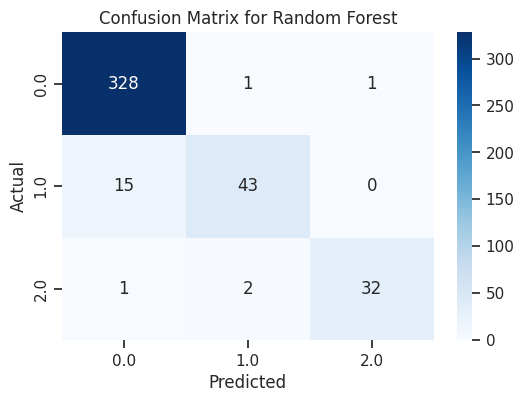

In [37]:
cm = confusion_matrix(y_test, rf_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest')
plt.show()

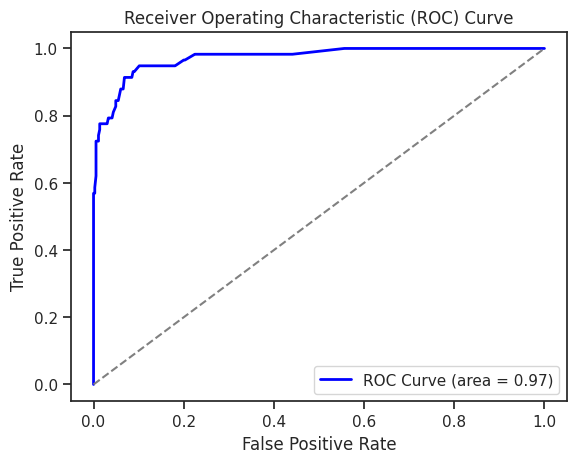

In [38]:
# Generate ROC Curve
rf_probs = random_forest_model.predict_proba(X_test)[:, 1]  # Probability for positive class
fpr, tpr, _ = roc_curve(y_test, rf_probs, pos_label=np.unique(y_test)[1])
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [39]:
# Assuming 'model' is your trained Scikit-Learn model
joblib.dump(random_forest_model, "Random_Forest.pkl")

# Convert to H5 (Corrected method)
with h5py.File("Random_Forest.h5", "w") as f:
    # Serialize the model into a byte stream
    model_bytes = io.BytesIO()
    joblib.dump(random_forest_model, model_bytes)
print("Scikit-Learn model saved as 'Random_Forest.pkl' and 'Random_Forest.h5' successfully!")

Scikit-Learn model saved as 'Random_Forest.pkl' and 'Random_Forest.h5' successfully!


# MLPC

In [40]:
mlp = MLPClassifier(max_iter = 800, learning_rate_init = 0.05,  early_stopping = True)
mlp.fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
accuracy_mlp = accuracy_score(y_test, y_pred_mlp)
print("Accuracy MLP: ", accuracy_mlp)

Accuracy MLP:  0.7966903073286052


In [41]:
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88       330
         1.0       0.45      0.43      0.44        58
         2.0       0.52      0.69      0.59        35

    accuracy                           0.80       423
   macro avg       0.62      0.66      0.64       423
weighted avg       0.80      0.80      0.80       423



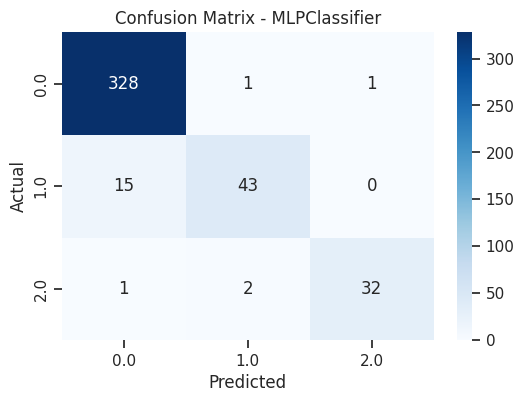

In [42]:
# Plot Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - MLPClassifier')
plt.show()

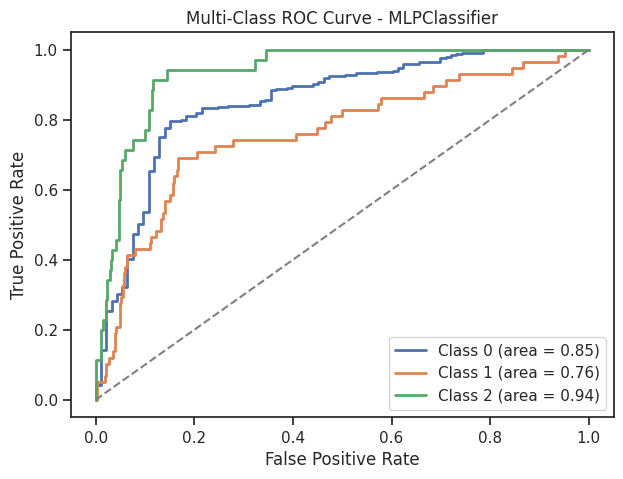

In [43]:
# Binarize labels for multi-class ROC curve
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_score = mlp.predict_proba(X_test)  # Get probability scores
# Plot ROC Curve for each class
plt.figure(figsize=(7, 5))
for i in range(y_test_bin.shape[1]):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'Class {i} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve - MLPClassifier')
plt.legend(loc='lower right')
plt.show()

In [44]:
# Assuming 'model' is your trained Scikit-Learn model
joblib.dump(MLPClassifier, "MLPC.pkl")

# Convert to H5 (Corrected method)
with h5py.File("MLPC.h5", "w") as f:
    # Serialize the model into a byte stream
    model_bytes = io.BytesIO()
    joblib.dump(MLPClassifier, model_bytes)
print("Scikit-Learn model saved as 'MLPC.pkl' and 'MLPC.h5' successfully!")

Scikit-Learn model saved as 'MLPC.pkl' and 'MLPC.h5' successfully!


# XGBoost

In [45]:
xgb = XGBClassifier(objective='binary:logistic', seed=42)
xgb.fit(X_train, y_train)

print (xgb.score(X_train , y_train))
print (xgb.score(X_test , y_test))

0.9988165680473373
0.9598108747044918


In [46]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [ 3, 4, 5, 6], #Maximum depth of a tree.
    'learning_rate': [0.01, 0.1, 0.2, 0.3], #Step size shrinkage used in update to prevent overfitting.
    'subsample': [0.8, 0.9, 1.0], # Subsample ratio of the training instances, setting to 0.5 means XGBoost would randomly sample half of the training data prior to growing trees and this will prevent overfitting.
    'colsample_bytree': [0.8, 0.9, 1.0], # Subsample ratio of columns when constructing each tree. Subsampling occurs once for every tree constructed.
}

grid_search = GridSearchCV(estimator = xgb, param_grid = param_grid, scoring = 'accuracy', cv = 5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

best_xgb = grid_search.best_estimator_

best_xgb.score(X_train, y_train)

best_params

{'colsample_bytree': 1.0,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 100,
 'subsample': 1.0}

In [47]:
# Create an XGBoost classifier with the best hyperparameters
best_xgb = XGBClassifier(**best_params)

best_xgb.fit(X_train, y_train)

y_pred_xgb = best_xgb.predict(X_test)

print (best_xgb.score(X_train , y_train))
print (best_xgb.score(X_test , y_test))

0.9988165680473373
0.9598108747044918


In [48]:
print(classification_report(y_test, y_pred_xgb))

              precision    recall  f1-score   support

         0.0       0.96      0.99      0.98       330
         1.0       0.94      0.76      0.84        58
         2.0       1.00      0.97      0.99        35

    accuracy                           0.96       423
   macro avg       0.97      0.91      0.93       423
weighted avg       0.96      0.96      0.96       423



In [50]:
# Predictions
y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)


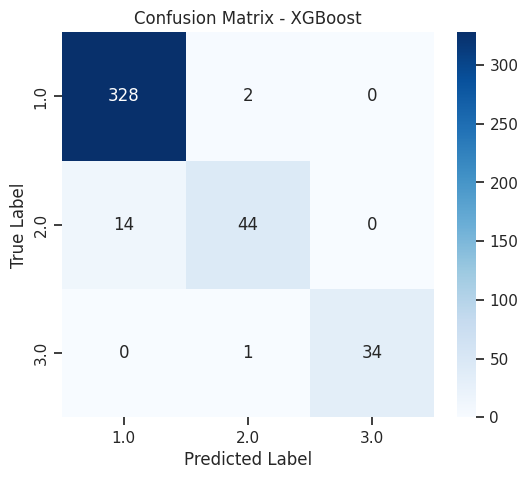

In [51]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost')
plt.show()


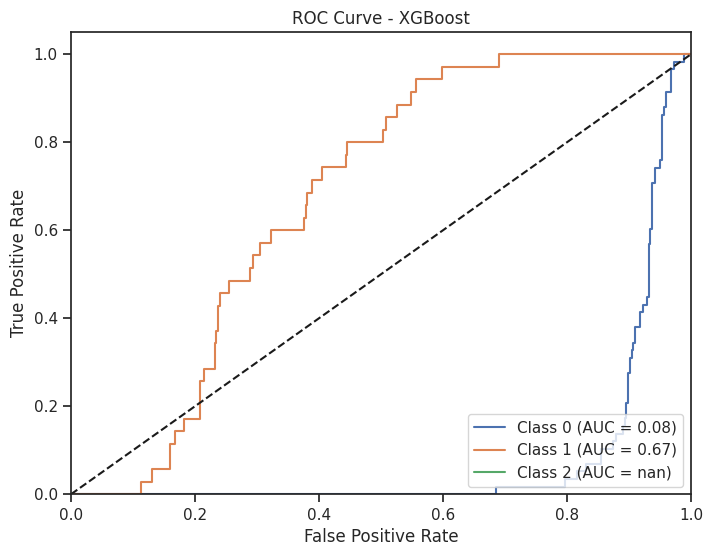

In [52]:
# Compute ROC Curve (for multi-class, one-vs-rest)
y_bin = label_binarize(y_test, classes=np.unique(y))
n_classes = y_bin.shape[1]

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_bin[:, i], y_pred_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random chance line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - XGBoost')
plt.legend(loc='lower right')
plt.show()


In [53]:
# Assuming 'model' is your trained Scikit-Learn model
joblib.dump(XGBClassifier, "XG Boost.pkl")

# Convert to H5 (Corrected method)
with h5py.File("XG Boost.h5", "w") as f:
    # Serialize the model into a byte stream
    model_bytes = io.BytesIO()
    joblib.dump(XGBClassifier, model_bytes)
print("Scikit-Learn model saved as 'XG Boost.pkl' and 'XG Boost.h5' successfully!")

Scikit-Learn model saved as 'XG Boost.pkl' and 'XG Boost.h5' successfully!


# AdaBoost

In [55]:
base_estimator = RandomForestClassifier(n_estimators = 100)
ada = AdaBoostClassifier(estimator=base_estimator, n_estimators=6, learning_rate=0.01)

In [56]:
ada.fit(X_train, y_train)

AdaBoostClassifier(estimator=RandomForestClassifier(), learning_rate=0.01,
                   n_estimators=6)

In [57]:
print (ada.score(X_train , y_train))
print (ada.score(X_test , y_test))

0.9988165680473373
0.9527186761229315


In [58]:
y_pred_ada = ada.predict(X_test)
print(classification_report(y_test, y_pred_mlp))

              precision    recall  f1-score   support

         0.0       0.90      0.87      0.88       330
         1.0       0.45      0.43      0.44        58
         2.0       0.52      0.69      0.59        35

    accuracy                           0.80       423
   macro avg       0.62      0.66      0.64       423
weighted avg       0.80      0.80      0.80       423



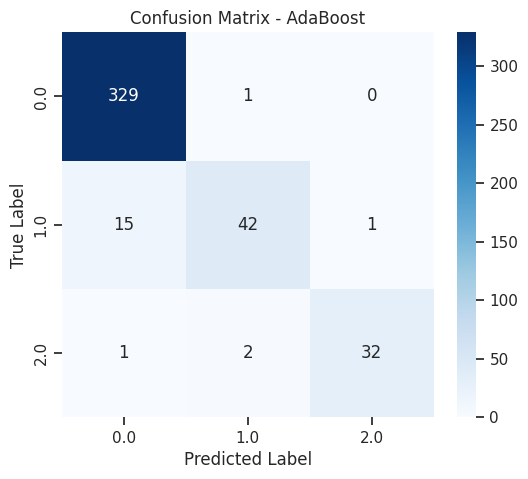

In [59]:
# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_ada)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - AdaBoost")
plt.show()

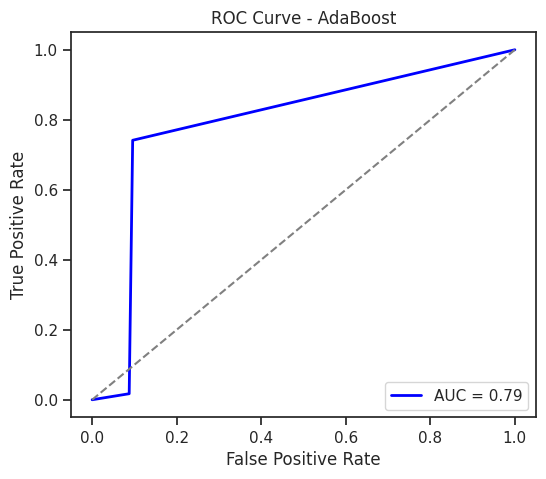

In [60]:
# Compute ROC Curve and AUC Score
fpr, tpr, _ = roc_curve(y_test,  y_pred_ada, pos_label=ada.classes_[1])
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - AdaBoost")
plt.legend(loc="lower right")
plt.show()

In [61]:
# Assuming 'model' is your trained Scikit-Learn model
joblib.dump(AdaBoostClassifier, "Ada Boost.pkl")

# Convert to H5 (Corrected method)
with h5py.File("Ada Boost.h5", "w") as f:
    # Serialize the model into a byte stream
    model_bytes = io.BytesIO()
    joblib.dump(AdaBoostClassifier, model_bytes)
print("Scikit-Learn model saved as 'Ada Boost.pkl' and 'Ada Boost.h5' successfully!")

Scikit-Learn model saved as 'Ada Boost.pkl' and 'Ada Boost.h5' successfully!


# Catboost

In [76]:
from catboost import CatBoostClassifier
# Initialize CatBoostClassifier
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=100)

# Train the model (Make sure X_train and y_train are defined)
model.fit(X_train, y_train)


0:	learn: 0.9663570	total: 3.2ms	remaining: 1.6s
100:	learn: 0.1195034	total: 286ms	remaining: 1.13s
200:	learn: 0.0741990	total: 555ms	remaining: 826ms
300:	learn: 0.0513831	total: 803ms	remaining: 531ms
400:	learn: 0.0384805	total: 1.05s	remaining: 260ms
499:	learn: 0.0302603	total: 1.3s	remaining: 0us


In [73]:
# Now, make predictions on the test set
y_pred = model.predict(X_test)
y_pred = np.array(y_pred).flatten()  # Flatten if needed

In [74]:
print("Predictions:", y_pred)
y_proba = model.predict_proba(X_test)  # Get probability scores


Predictions: [0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 0. 0.
 2. 1. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 2.
 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 1. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 1. 2. 0. 1. 0. 0. 0. 2.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 2. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 1.
 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 2. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2

In [75]:

print("Predictions:", y_pred)
print("Probability Scores:", y_proba)


Predictions: [0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 2. 0. 0. 0. 0. 0.
 2. 1. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 2.
 0. 0. 0. 0. 1. 0. 2. 0. 0. 0. 0. 0. 1. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0. 1. 2. 0. 1. 0. 0. 0. 2.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 2. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 2. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1.
 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.
 0. 1. 0. 0. 2. 0. 0. 0. 0. 0. 2. 2. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 2. 1.
 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 2. 0. 0. 0. 2. 2. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 2. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0.
 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 2. 0. 1. 0. 0. 0. 0. 0. 0. 0. 2

In [65]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9574468085106383
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      1.00      0.97       330
         1.0       0.95      0.72      0.82        58
         2.0       1.00      0.97      0.99        35

    accuracy                           0.96       423
   macro avg       0.97      0.90      0.93       423
weighted avg       0.96      0.96      0.95       423



In [77]:
# Debugging: Check shape
print("y_proba shape:", y_proba.shape)
print("Unique values in y_test:", np.unique(y_test))

y_proba shape: (423, 3)
Unique values in y_test: [0. 1. 2.]


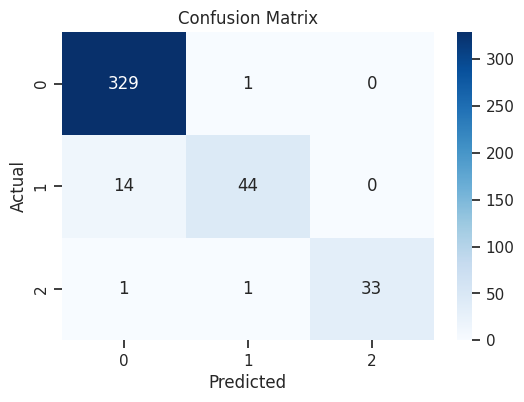

In [78]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

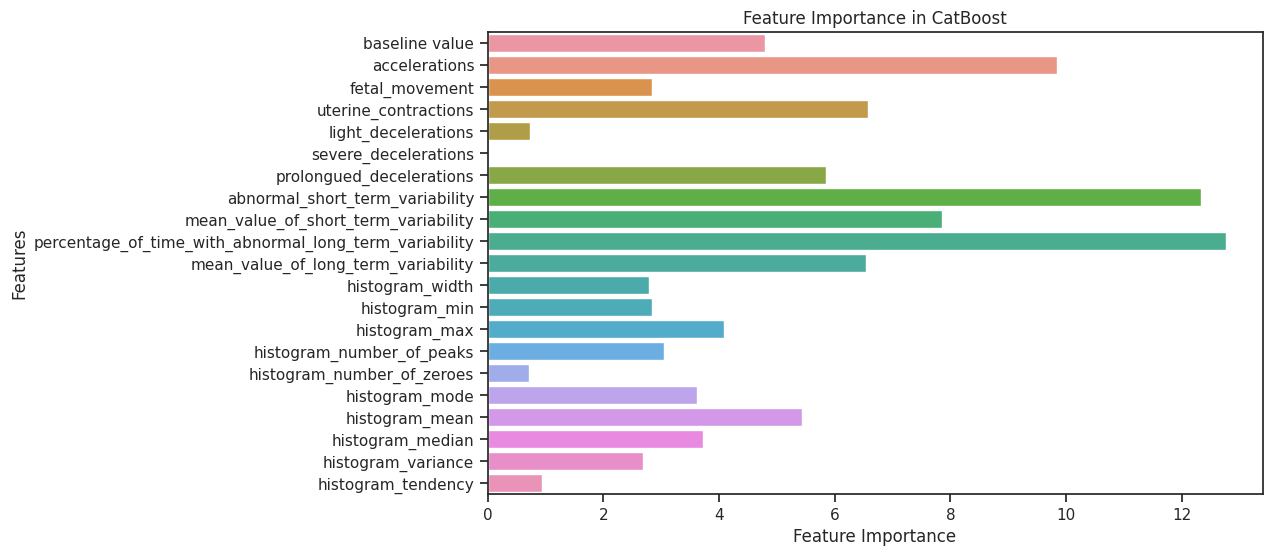

In [79]:
# Feature Importance
feature_importance = model.get_feature_importance()
feature_names = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in CatBoost")
plt.show()


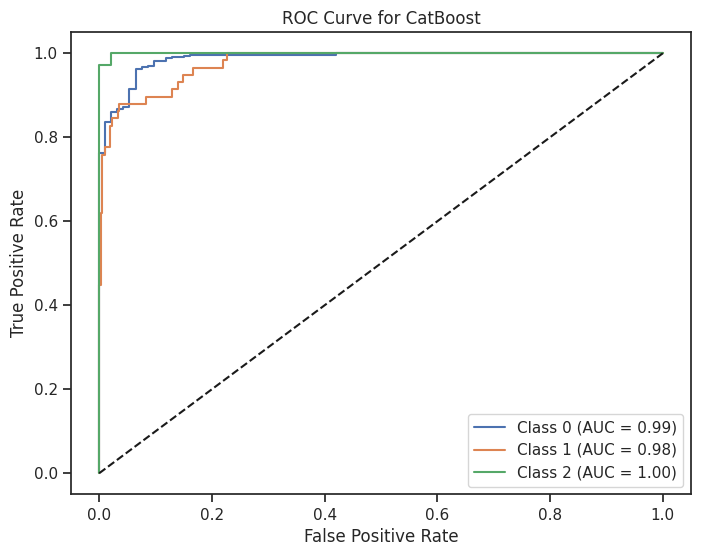

In [80]:
# ROC Curve (For Multiclass Classification)
plt.figure(figsize=(8, 6))
n_classes = len(np.unique(y_test))  # Get number of unique classes

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test, y_proba[:, i], pos_label=i)  # Use y_proba
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for CatBoost')
plt.legend()
plt.show()


In [81]:
# Assuming 'model' is your trained Scikit-Learn model
joblib.dump( CatBoostClassifier, "Cat Boost.pkl")

# Convert to H5 (Corrected method)
with h5py.File("Cat Boost.h5", "w") as f:
    # Serialize the model into a byte stream
    model_bytes = io.BytesIO()
    joblib.dump( CatBoostClassifier, model_bytes)
print("Scikit-Learn model saved as 'Cat Boost.pkl' and 'Cat Boost.h5' successfully!")

Scikit-Learn model saved as 'Cat Boost.pkl' and 'Cat Boost.h5' successfully!


# LGBM(Light Gradient Boosting Machine)

In [83]:
from lightgbm import early_stopping
# Initialize the LightGBM Classifier
model = LGBMClassifier(
    n_estimators=500, learning_rate=0.1, max_depth=6, verbose=-1
)

In [84]:
# Train the model
model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    callbacks=[early_stopping(stopping_rounds=50)]
)
# Predictions
y_pred = model.predict(X_test)

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[60]	valid_0's multi_logloss: 0.130012


In [85]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.9621749408983451
Classification Report:
               precision    recall  f1-score   support

         0.0       0.96      1.00      0.98       330
         1.0       0.98      0.78      0.87        58
         2.0       0.94      0.94      0.94        35

    accuracy                           0.96       423
   macro avg       0.96      0.91      0.93       423
weighted avg       0.96      0.96      0.96       423



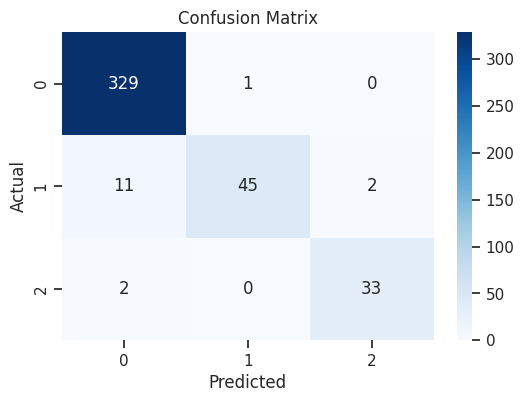

In [86]:
# Confusion Matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

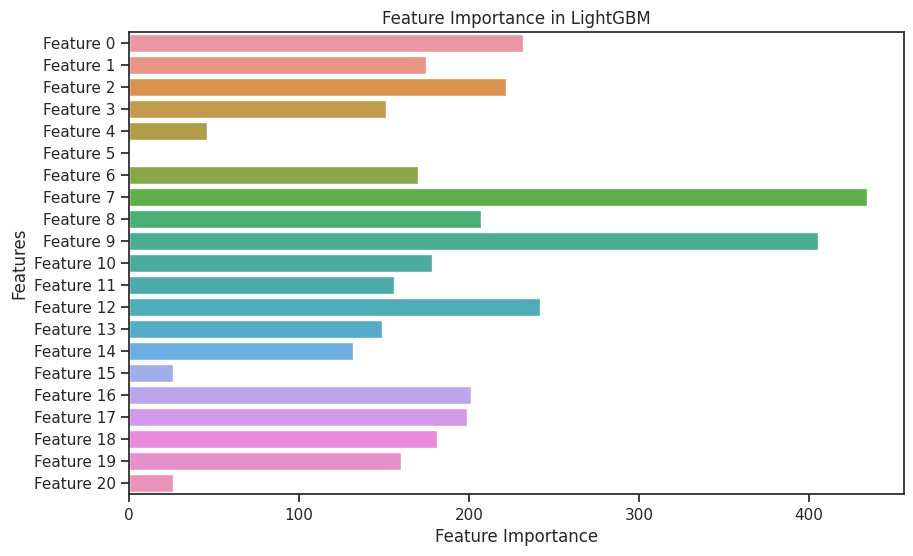

In [87]:
# Feature Importance
feature_importance = model.feature_importances_
feature_names = [f"Feature {i}" for i in range(X_train.shape[1])]

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance in LightGBM")
plt.show()


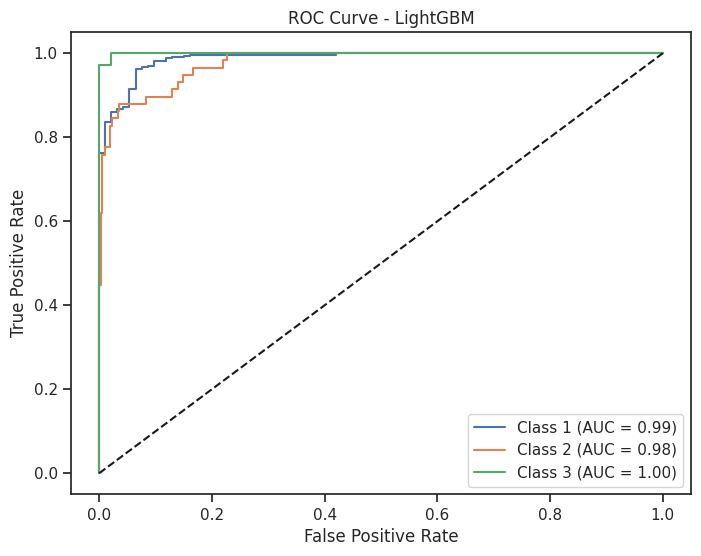

In [88]:
# Plot ROC Curve for each class
plt.figure(figsize=(8,6))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i+1} (AUC = {roc_auc:.2f})')

# Plot Settings
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc="lower right")
plt.show()

In [89]:
# Assuming 'model' is your trained Scikit-Learn model
joblib.dump( LGBMClassifier, "LGBM.pkl")

# Convert to H5 (Corrected method)
with h5py.File("LGBM.h5", "w") as f:
    # Serialize the model into a byte stream
    model_bytes = io.BytesIO()
    joblib.dump(LGBMClassifier, model_bytes)
print("Scikit-Learn model saved as 'LGBM.pkl' and 'LGBM.h5' successfully!")

Scikit-Learn model saved as 'LGBM.pkl' and 'LGBM.h5' successfully!


# Gaussian Naive Bayes

In [90]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [91]:
# Create the Gaussian Naive Bayes classifier
gnb = GaussianNB()

# Train the model
gnb.fit(X_train, y_train)

# Make predictions
y_pred = gnb.predict(X_test)

In [92]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))



Accuracy: 0.80

Classification Report:
              precision    recall  f1-score   support

         1.0       0.98      0.82      0.89       330
         2.0       0.44      0.83      0.57        58
         3.0       0.53      0.57      0.55        35

    accuracy                           0.80       423
   macro avg       0.65      0.74      0.67       423
weighted avg       0.87      0.80      0.82       423



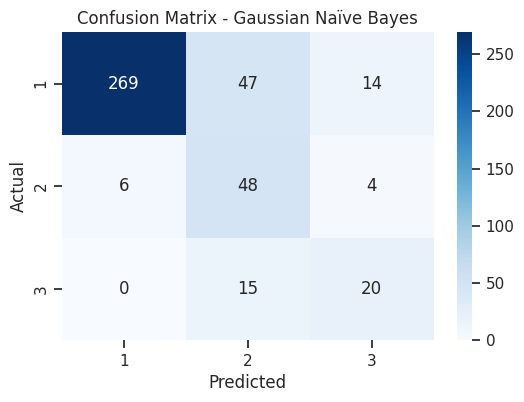

In [93]:
# Predictions
y_pred = gnb.predict(X_test)
y_prob = gnb.predict_proba(X_test)  # Get probability estimates for ROC

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Gaussian Naïve Bayes")
plt.show()

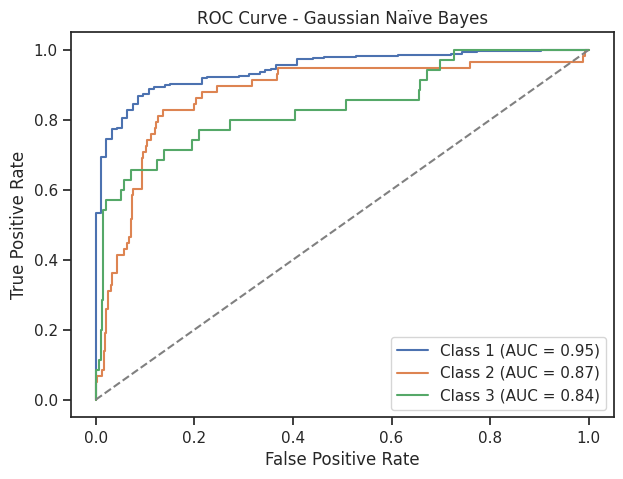

In [94]:
# ROC Curve (for multi-class classification)
y_test_bin = label_binarize(y_test, classes=[1, 2, 3])  # Convert labels to one-hot encoding
n_classes = y_test_bin.shape[1]

plt.figure(figsize=(7,5))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i+1} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], linestyle="--", color="gray")  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Gaussian Naïve Bayes")
plt.legend()
plt.show()

In [95]:
# Assuming 'model' is your trained Scikit-Learn model
joblib.dump(gnb, "Gaussian Naive Bayes.pkl")

# Convert to H5 (Corrected method)
with h5py.File("Gaussian Naive Bayes.h5", "w") as f:
    # Serialize the model into a byte stream
    model_bytes = io.BytesIO()
    joblib.dump( gnb, model_bytes)
print("Scikit-Learn model saved as 'Gaussian Naive Bayes.pkl' and 'Gaussian Naive Bayes.h5' successfully!")

Scikit-Learn model saved as 'Gaussian Naive Bayes.pkl' and 'Gaussian Naive Bayes.h5' successfully!


# Comaparison of all Classifiers

In [96]:
# Adjust class labels to start from 0
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1


In [97]:
accuracy_scores = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train_adjusted)  # Train with adjusted labels
    y_pred = clf.predict(X_test)
    y_pred_adjusted = y_pred + 1  # Convert predictions back to original labels
    accuracy = accuracy_score(y_test, y_pred_adjusted)
    accuracy_scores[name] = accuracy
    print(f"{name} Accuracy: {accuracy:.4f}")


Random Forest Accuracy: 0.9527
XGBoost Accuracy: 0.9598
AdaBoost Accuracy: 0.8913
MLPClassifier Accuracy: 0.8369
Gaussian Naive Bayes Accuracy: 0.7967
CatBoost Accuracy: 0.9551
LGBM Accuracy: 0.9598


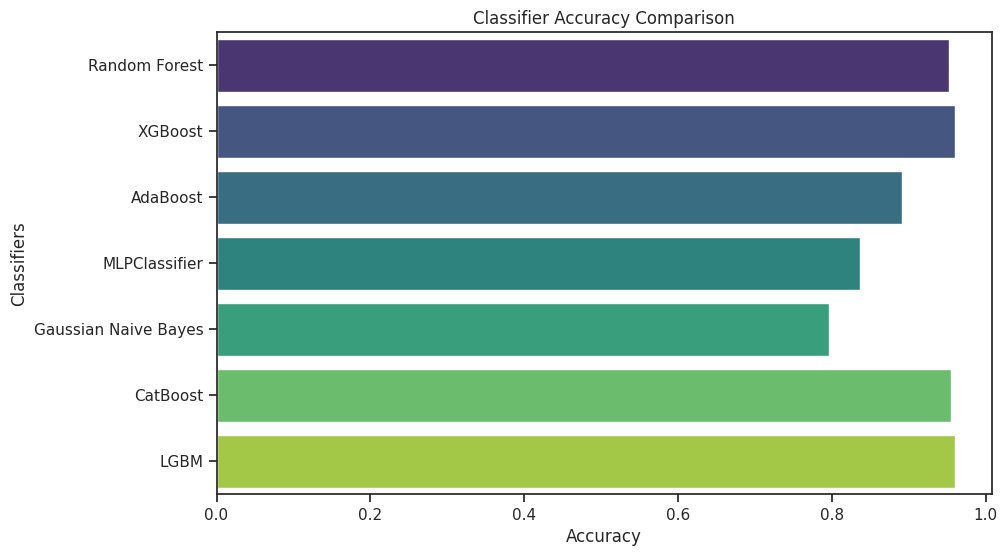

In [98]:
# Visualize accuracy scores
plt.figure(figsize=(10, 6))
sns.barplot(x=list(accuracy_scores.values()), y=list(accuracy_scores.keys()), palette='viridis')
plt.xlabel("Accuracy")
plt.ylabel("Classifiers")
plt.title("Classifier Accuracy Comparison")
plt.show()    
    

In [99]:
top_3_classifiers = sorted(accuracy_scores.items(), key=lambda x: x[1], reverse=True)[:3]


In [100]:
# Display top 3 classifiers
print("\nTop 3 Classifiers Based on Accuracy:")
for rank, (name, acc) in enumerate(top_3_classifiers, 1):
    print(f"{rank}. {name}: {acc:.4f}")


Top 3 Classifiers Based on Accuracy:
1. XGBoost: 0.9598
2. LGBM: 0.9598
3. CatBoost: 0.9551


# Weighted ensemble on 3 best model 

In [101]:
# Extract best models
best_model_1 = classifiers[top_3_classifiers[0][0]]
best_model_2 = classifiers[top_3_classifiers[1][0]]
best_model_3 = classifiers[top_3_classifiers[2][0]]

# Assuming you have top 3 models stored as a dictionary
top_models = {'ML1': best_model_1, 'ML2': best_model_2, 'ML3': best_model_3}

# Display top 3 classifiers
print("\nTop 3 Classifiers Based on Accuracy:")
for rank, (name, acc) in enumerate(top_3_classifiers, 1):
    print(f"{rank}. {name}: {acc:.4f}")
    
# Weighted Averaging Ensemble
probs_1 = top_models['ML1'].predict_proba(X_test)
probs_2 = top_models['ML2'].predict_proba(X_test)
probs_3 = top_models['ML3'].predict_proba(X_test)

# Initial Equal Weights
weights = [0.33, 0.33, 0.33]
avg_probs = (weights[0] * probs_1) + (weights[1] * probs_2) + (weights[2] * probs_3)
weighted_preds = np.argmax(avg_probs, axis=1)

# Evaluate Weighted Ensemble
weighted_accuracy = accuracy_score(y_test, weighted_preds)
print(f'Weighted Averaging Ensemble Accuracy: {weighted_accuracy:.4f}')


Top 3 Classifiers Based on Accuracy:
1. XGBoost: 0.9598
2. LGBM: 0.9598
3. CatBoost: 0.9551
Weighted Averaging Ensemble Accuracy: 0.0047


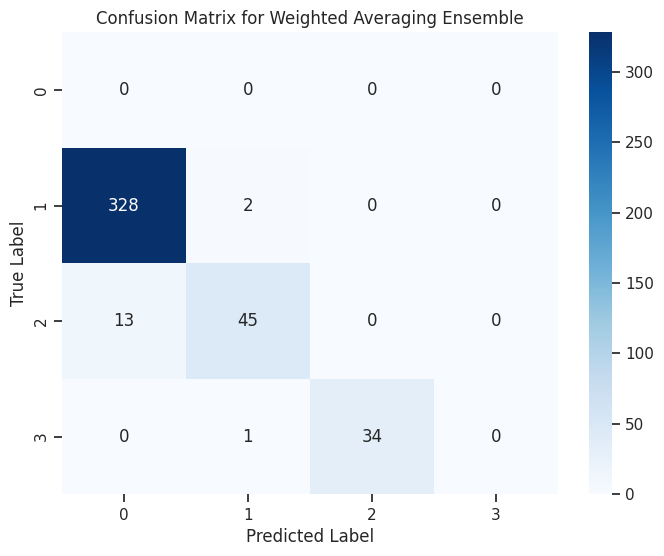

In [102]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, weighted_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Weighted Averaging Ensemble')
plt.show()


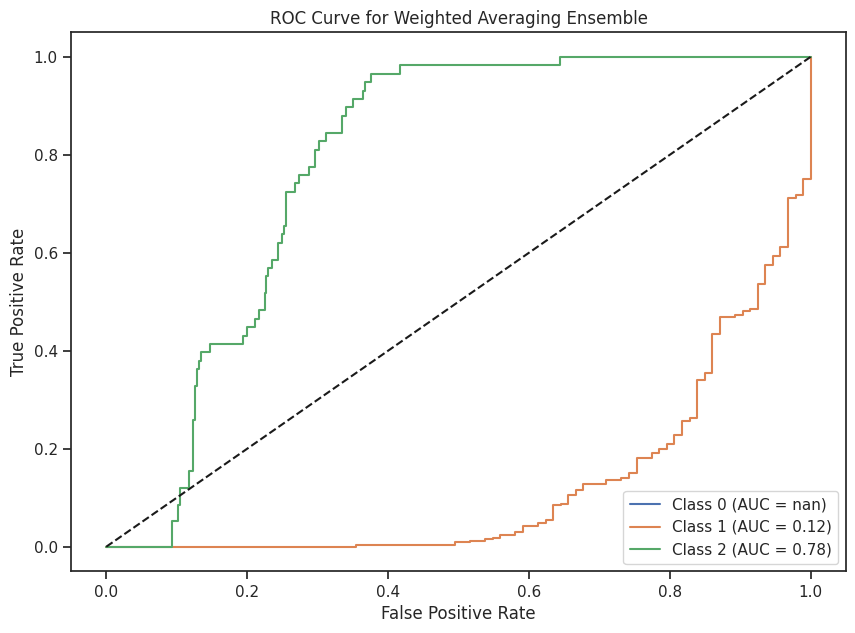

In [103]:
# ROC Curve
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, avg_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 7))
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Weighted Averaging Ensemble')
plt.legend(loc='lower right')
plt.show()

# Stacked ensemble on 3 best model

In [104]:
# Stacking Ensemble (Meta-Classifier: Random Forest)
stacking_model = StackingClassifier(
    estimators=[('ML1', top_models['ML1']), ('ML2', top_models['ML2']), ('ML3', top_models['ML3'])],
    final_estimator=RandomForestClassifier(n_estimators=100, random_state=42)
)
stacking_model.fit(X_train, y_train)
stacking_preds = stacking_model.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_preds)
print(f'Stacking Ensemble Accuracy: {stacking_accuracy:.4f}')


Stacking Ensemble Accuracy: 0.9480


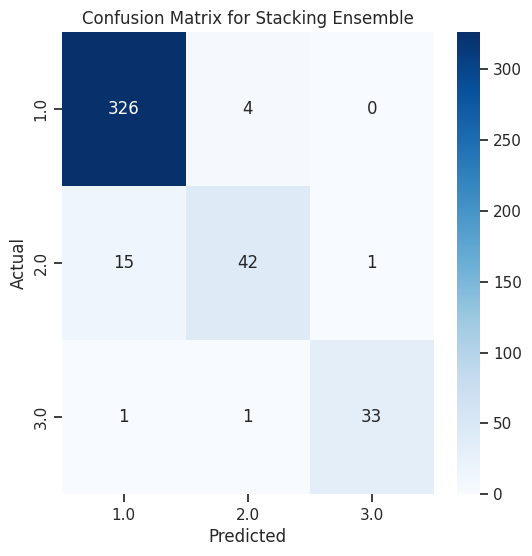

In [105]:
# Confusion Matrix
plt.figure(figsize=(6, 6))
cm = confusion_matrix(y_test, stacking_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Stacking Ensemble')
plt.show()

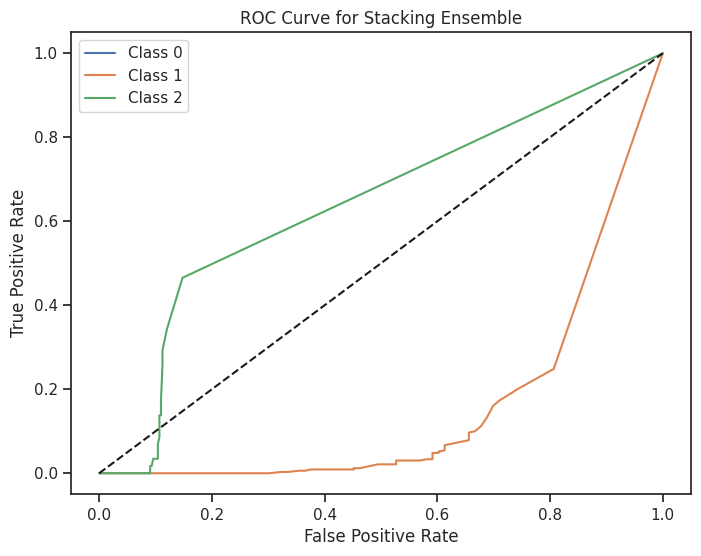

In [106]:
# ROC Curve
plt.figure(figsize=(8, 6))
stacking_probs = stacking_model.predict_proba(X_test)
for i in range(len(np.unique(y_test))):
    fpr, tpr, _ = roc_curve(y_test, stacking_probs[:, i], pos_label=i)
    plt.plot(fpr, tpr, label=f'Class {i}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Stacking Ensemble')
plt.legend()
plt.show()

# Voting ensemble on 3 best model 

In [107]:
# Voting Classifier (Hard & Soft Voting)
voting_model = VotingClassifier(
    estimators=[('ML1', top_models['ML1']), ('ML2', top_models['ML2']), ('ML3', top_models['ML3'])],
    voting='soft'  # Use 'hard' for majority class selection
)
voting_model.fit(X_train, y_train)
voting_preds = voting_model.predict(X_test)
voting_accuracy = accuracy_score(y_test, voting_preds)
print(f'Voting Ensemble Accuracy: {voting_accuracy:.4f}')


Voting Ensemble Accuracy: 0.9622


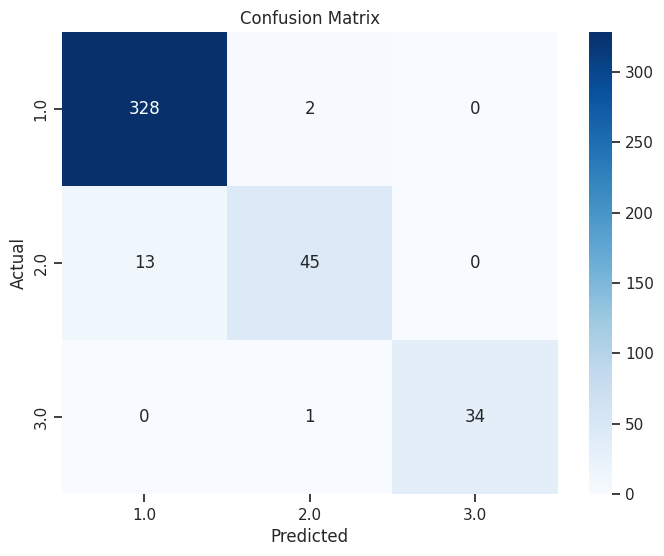

In [108]:
# Generate Confusion Matrix
conf_matrix = confusion_matrix(y_test, voting_preds)
plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

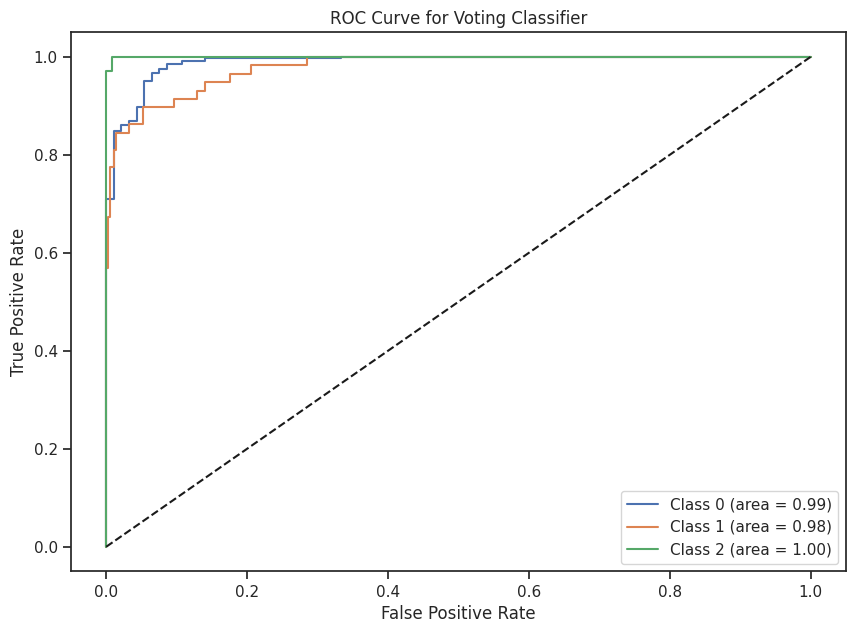

In [109]:
# ROC Curve for Voting Classifier
if len(np.unique(y_test)) > 2:
    from sklearn.preprocessing import label_binarize
    from sklearn.metrics import roc_auc_score
    
    y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
    y_score = voting_model.predict_proba(X_test)
    n_classes = y_test_bin.shape[1]
    
    plt.figure(figsize=(10, 7))
    for i in range(n_classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'Class {i} (area = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve for Voting Classifier')
    plt.legend()
    plt.show()
else:
    fpr, tpr, _ = roc_curve(y_test, voting_model.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='grey', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()
